In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import json

In [37]:
## Global Params
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["font.size"] = 18  # Adjust the font size
colors = ['#a8ddb5', '#7bccc4', '#43a2ca','#0868ac']

## Global Params


def read_text_files(directory,component,number,label):
    text_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r') as file:
                d={
                'In-Flight':0,
                'Throughput':0,
                'Latency(ms)': 0,
                'ScaleFactor': component,
                "# of Components":number,
                "Label":label
                }
                for line in file:
                    if line.startswith("In-Flight Requests"):
                        inFlight = int(line.split(' ')[2].strip())
                        d['In-Flight']=inFlight
                    if line.startswith("Ops/s"):
                        parts = line.split(',')
                        throughput = int(parts[1])
                        d['Throughput']=throughput/30
                    
                    if line.startswith("Average Latency"):
                        latency = int(line.split(' ')[2])
                        d['Latency(ms)']=latency
                
                text_data.append(d)
    return text_data



def read_json_files_to_df(directory,label):
    throughput_data = []
    experiment_number = 1
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                throughput = data.get('Goodput (requests/second)', None)
                latency = data.get('Latency Distribution', None).get('Average Latency (microseconds)',None)
                if latency is not None:
                    latency = latency/1000
                if throughput is not None and latency is not None:
                    throughput_data.append({'Experiment': f'Experiment {experiment_number}', 'Throughput': throughput, "Latency(ms)":latency, "Label":label})
                    experiment_number += 1
    return pd.DataFrame(throughput_data)

### Scaling 

/tmp/ipykernel_2779942/2073812998.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=proxyDF, x='Machines', y='Throughput', err_style='bars', err_kws={'ecolor': 'black'}, palette=colors,linewidth=2)


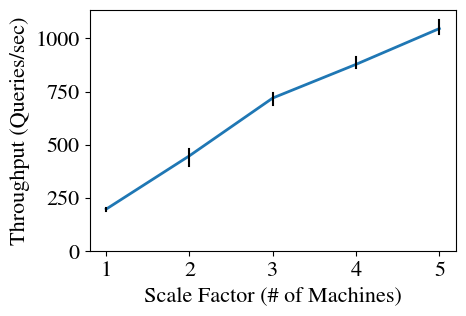

In [38]:
scaleOne = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/Scalingto5/Scale1' 
scaleTwo = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/Scalingto5/Scale2'
ScaleThree = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/Scalingto5/Scale3' 
ScaleFour = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/Scalingto5/Scale4'
ScaleFive = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/Scalingto5/Scale5'


readScaleOne = read_text_files(scaleOne, '1', 3, "10ms-Latency")
readScaleTwo = read_text_files(scaleTwo, '2', 3, "10ms-Latency")
readScaleThree = read_text_files(ScaleThree, '3', 3, "10ms-Latency")
readScaleFour = read_text_files(ScaleFour, '4', 3, "10ms-Latency")
readScaleFive = read_text_files(ScaleFive, '5', 3, "10ms-Latency")

oneDF = pd.DataFrame(readScaleOne)
twoDF = pd.DataFrame(readScaleTwo)
threeDF = pd.DataFrame(readScaleThree)
fourDF = pd.DataFrame(readScaleFour)
fiveDF = pd.DataFrame(readScaleFive)


proxyDF = pd.concat([
    oneDF, twoDF, threeDF, fourDF,fiveDF])

proxyDF.rename(columns={'ScaleFactor': 'Machines','Label':"Latency"}, inplace=True)


fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust for double-column if needed

sns.lineplot(data=proxyDF, x='Machines', y='Throughput', err_style='bars', err_kws={'ecolor': 'black'}, palette=colors,linewidth=2)


ax.set_xlabel("Scale Factor (# of Machines)",fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
# ax.set_yscale("log")
ax.set_ylim(bottom=0)
# ax.set_title("Comparison: ObliDB, ObliSQL(Waffle) and ObliSQL(ORAM)",fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=16)
# plt.show()

fig = ax.get_figure()
fig.tight_layout()
# fig.tight_layout()
fig.savefig("/home/haseeb/Desktop/ReviewGraphs/Figures/ORAMScale.png", format='png')

In [39]:
grouped_df = proxyDF.groupby(['Machines']).agg({
    'Throughput': 'mean',
    'Latency(ms)': 'mean',
}).reset_index()

grouped_df

,Machines,Throughput,Latency(ms)
0,1,197.533333,890.333333
1,2,448.388889,880.666667
2,3,719.944444,887.000000
3,4,878.288889,942.000000
4,5,1046.500000,975.666667


### Join Bloom

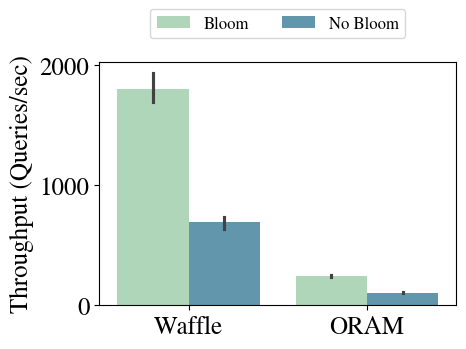

In [40]:
# 1) Paths to your two sets of join‐bloom results:
paths = {
    'Waffle': "/home/haseeb/Desktop/ReviewGraphs/NewORAM/Join/Waffle/JoinBloom",
    'ORAM':   "/home/haseeb/Desktop/ReviewGraphs/NewORAM/Join/ORAM/JoinBloom"
}

method_palette = {
    'Bloom': '#a8ddb5',
    'No Bloom':   '#549bb9'
}


# 2) Read in just the Hybrid + Default (No Bloom) runs, rename Hybrid→Bloom:
frames = []
for method, base in paths.items():
    # Hybrid directory (rename label)
    df_h = pd.DataFrame(read_text_files(f"{base}/Hybrid", "3", "3", "Hybrid"))
    df_h['Label'] = 'Bloom'
    # Default directory = No Bloom
    df_n = pd.DataFrame(read_text_files(f"{base}/Default", "3", "3", "No Bloom"))
    df_n['Label'] = 'No Bloom'
    
    # tag with method and append
    df_h['Method'] = method
    df_n['Method'] = method
    frames += [df_h, df_n]

merged = pd.concat(frames, ignore_index=True)
# 3) Plot with seaborn + log scale on y-axis
fig, ax = plt.subplots(figsize=(5, 4))
sns.barplot(
    data=merged,
    x='Method',
    y='Throughput',
    hue='Label',
    order=['Waffle', 'ORAM'],
    hue_order=['Bloom', 'No Bloom'],
    palette=method_palette,
    ax=ax
)
# ax.set_yscale('log')
# ax.set_ylim(bottom=1)

ax.set_xlabel('')
ax.set_ylabel('Throughput (Queries/sec)')
# ax.set_title('JBloom vs. No Bloom ')
# ax.legend(title='', fontsize=12, loc='upper right')
ax.legend(title='', fontsize=12, markerscale=1.5, 
          loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4)
fig.tight_layout()
plt.show()

# Save the figure
fig.savefig("/home/haseeb/Desktop/ReviewGraphs/Figures/JoinQueries.png", format='png')

In [41]:
merged.groupby(["Method", "Label"]).agg({'Throughput': 'mean'})


Throughput
Method Label                
ORAM   Bloom      246.477778
       No Bloom   105.566667
Waffle Bloom     1800.466667
       No Bloom   694.400000

### Range Bloom

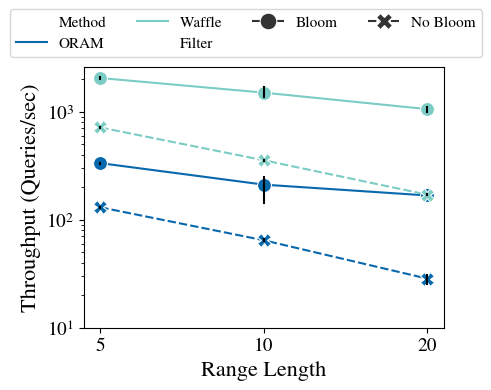

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- load your data as before, then add a Method column ---
def load_range_data(base_path, method_name):
    dfs = []
    for sel in ['5','10','20']:
        for label, sub in [('Bloom','Bloom'), ('NoBloom','NoBloom')]:
            path = f"{base_path}/Range{sel}/{label}"
            data = read_text_files(path, sel, 3, label.replace('NoBloom','No Bloom'))
            df = pd.DataFrame(data)
            df.rename(columns={'ScaleFactor':'Selectivity', 'Label':'Filter'}, inplace=True)
            df['Method'] = method_name
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# load both
oram_df   = load_range_data('/home/haseeb/Desktop/ReviewGraphs/NewORAM/Range/ORAM/DefaultRange', 'ORAM')
waffle_df = load_range_data('/home/haseeb/Desktop/ReviewGraphs/NewORAM/Range/Waffle/RangeBloom/DefaultRange', 'Waffle')

# combine and sort
df = pd.concat([oram_df, waffle_df], ignore_index=True)
df['Selectivity'] = pd.Categorical(df['Selectivity'], categories=['5','10','20'], ordered=True)
df.sort_values('Selectivity', inplace=True)

# plot with wider figure
fig, ax = plt.subplots(figsize=(5, 4))  # Made wider (8 instead of 5) and slightly taller
sns.lineplot(
    data=df,
    x='Selectivity', y='Throughput',
    hue='Method', style='Filter',
    markers=True, dashes=True,
    err_style='bars', err_kws={'ecolor':'black'},
    palette=['#0868ac','#7bccc4'],
    markersize=10  # Increased marker size
)

# ax.set_yscale('log')
ax.set_xlabel("Range Length", fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
ax.set_yscale("log")
ax.set_ylim(bottom=10)
ax.tick_params(labelsize=14)

# Move legend above the plot
ax.legend(title='', fontsize=11, markerscale=1.2, 
          loc='upper center', bbox_to_anchor=(0.45, 1.25), ncol=4)

# Adjust layout to accommodate legend above
fig.tight_layout()
plt.subplots_adjust(top=0.85)  # Make room for legend above

plt.show()
fig.savefig("/home/haseeb/Desktop/ReviewGraphs/Figures/RangeQueries.png", format='png', 
            bbox_inches='tight', dpi=300)  # bbox_inches='tight' ensures legend is included

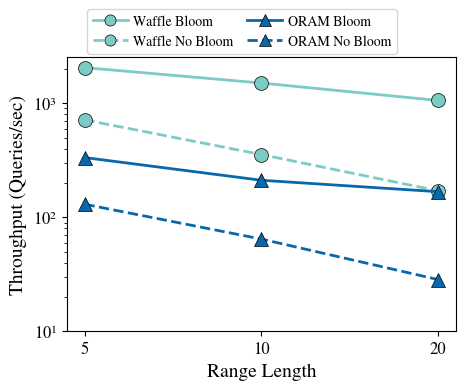

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- load your data as before, then add a Method column ---
def load_range_data(base_path, method_name):
    dfs = []
    for sel in ['5','10','20']:
        for label, sub in [('Bloom','Bloom'), ('NoBloom','NoBloom')]:
            path = f"{base_path}/Range{sel}/{label}"
            data = read_text_files(path, sel, 3, label.replace('NoBloom','No Bloom'))
            df = pd.DataFrame(data)
            df.rename(columns={'ScaleFactor':'Selectivity', 'Label':'Filter'}, inplace=True)
            df['Method'] = method_name
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# load both
oram_df   = load_range_data('/home/haseeb/Desktop/ReviewGraphs/NewORAM/Range/ORAM/DefaultRange', 'ORAM')
waffle_df = load_range_data('/home/haseeb/Desktop/ReviewGraphs/NewORAM/Range/Waffle/RangeBloom/DefaultRange', 'Waffle')

# combine and aggregate at the start
df_raw = pd.concat([oram_df, waffle_df], ignore_index=True)

# Aggregate the data to get mean values (avoiding error bars)
df = df_raw.groupby(['Selectivity', 'Method', 'Filter'])['Throughput'].mean().reset_index()
df['Selectivity'] = pd.Categorical(df['Selectivity'], categories=['5','10','20'], ordered=True)
df.sort_values('Selectivity', inplace=True)

# plot with paper-friendly figure size
fig, ax = plt.subplots(figsize=(5, 3.5))

# Plot each combination separately for better control
for method in ['Waffle', 'ORAM']:
    for filter_type in ['Bloom', 'No Bloom']:
        subset = df[(df['Method'] == method) & (df['Filter'] == filter_type)]
        
        # Set colors
        color = '#7bccc4' if method == 'Waffle' else '#0868ac'
        
        # Set markers
        marker = 'o' if method == 'Waffle' else '^'
        
        # Set line style
        linestyle = '-' if filter_type == 'Bloom' else '--'
        
        ax.plot(subset['Selectivity'], subset['Throughput'], 
                color=color, marker=marker, linestyle=linestyle, 
                markersize=10, linewidth=2, markeredgecolor='black', markeredgewidth=0.5)

ax.set_xlabel("Range Length", fontsize=14)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=14)
ax.set_yscale("log")
ax.set_ylim(bottom=10)
ax.tick_params(labelsize=12)

# Create custom legend with longer lines
legend_elements = [
    Line2D([0], [0], color='#7bccc4', marker='o', linestyle='-', 
           markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=0.5,
           label='Waffle Bloom'),
    Line2D([0], [0], color='#7bccc4', marker='o', linestyle='--', 
           markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=0.5,
           label='Waffle No Bloom'),
    Line2D([0], [0], color='#0868ac', marker='^', linestyle='-', 
           markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=0.5,
           label='ORAM Bloom'),
    Line2D([0], [0], color='#0868ac', marker='^', linestyle='--', 
           markersize=8, linewidth=2, markeredgecolor='black', markeredgewidth=0.5,
           label='ORAM No Bloom')
]

# Add legend above the plot with compact formatting
ax.legend(handles=legend_elements, fontsize=10, 
          loc='upper center', bbox_to_anchor=(0.45, 1.2), ncol=2,
          frameon=True, handlelength=2.5, handletextpad=0.4, columnspacing=1.0)

# Adjust layout for paper format
fig.tight_layout()
plt.subplots_adjust(top=1)  # Adjusted for smaller figure

plt.show()
fig.savefig("/home/haseeb/Desktop/ReviewGraphs/Figures/RangeQueries.png", format='png', 
            bbox_inches='tight', dpi=300)

In [82]:
df

,Selectivity,Method,Filter,Throughput
8,5,ORAM,Bloom,334.200000
9,5,ORAM,No Bloom,130.400000
10,5,Waffle,Bloom,2051.044444
11,5,Waffle,No Bloom,715.177778
0,10,ORAM,Bloom,211.288889
1,10,ORAM,No Bloom,64.522222
2,10,Waffle,Bloom,1502.133333
3,10,Waffle,No Bloom,355.233333
4,20,ORAM,Bloom,167.744444
5,20,ORAM,No Bloom,28.466667


## Per Layer Scaling

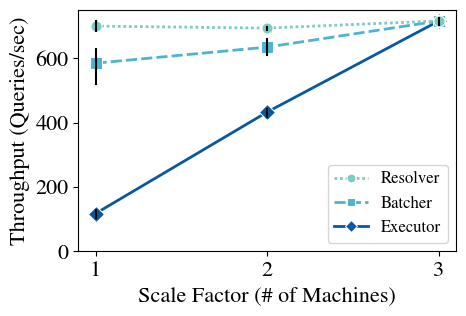

In [46]:
# Inflight - 650 -->ORAM

colors = ['#08589e','#4eb3d3',"#7bccc4"]
#resolver

resolverScalingOne = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/PerLayer/Resolver/1_3_3'
resolverScalingTwo = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/PerLayer/Resolver/2_3_3'
resolverScalingThree = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/PerLayer/Resolver/3_3_3'

oneResolver = read_text_files(resolverScalingOne,'1',3,"Resolver")
twoResolver = read_text_files(resolverScalingTwo,'2',3,"Resolver")
threeResolver = read_text_files(resolverScalingThree,'3',3,"Resolver")

oneResolverDF = pd.DataFrame(oneResolver)
twoResolverDF = pd.DataFrame(twoResolver)
threeResolverDF = pd.DataFrame(threeResolver)

resolverDF = pd.concat([oneResolverDF, twoResolverDF, threeResolverDF])


#Batcher
BatcherScalingOne = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/PerLayer/Batcher/3_1_3'
BatcherScalingTwo = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/PerLayer/Batcher/3_2_3'
BatcherScalingThree = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/PerLayer/Batcher/3_3_3'

oneBatcher = read_text_files(BatcherScalingOne,'1',3,"Batcher")
twoBatcher = read_text_files(BatcherScalingTwo,'2',3,"Batcher")
threeBatcher = read_text_files(BatcherScalingThree,'3',3,"Batcher")

oneBatcherDF = pd.DataFrame(oneBatcher)
twoBatcherDF = pd.DataFrame(twoBatcher)
threeBatcherDF = pd.DataFrame(threeBatcher)

batcherDF = pd.concat([oneBatcherDF, twoBatcherDF, threeBatcherDF])

#Proxy

ProxyScalingOne = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/PerLayer/Proxy/3_3_1'
ProxyScalingTwo = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/PerLayer/Proxy/3_3_2'
ProxyScalingThree = '/home/haseeb/Desktop/ReviewGraphs/NewORAM/PerLayer/Proxy/3_3_3'

oneProxy = read_text_files(ProxyScalingOne,'1',3,"Executor")
twoProxy = read_text_files(ProxyScalingTwo,'2',3,"Executor")
threeProxy = read_text_files(ProxyScalingThree,'3',3,"Executor")

oneProxyDF = pd.DataFrame(oneProxy)
twoProxyDF = pd.DataFrame(twoProxy)
threeProxyDF = pd.DataFrame(threeProxy)

proxyDF = pd.concat([oneProxyDF, twoProxyDF, threeProxyDF,oneBatcherDF,twoBatcherDF,threeBatcherDF,oneResolverDF,twoResolverDF,threeResolverDF])

fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust for double-column if needed

# Define marker styles for each category
marker_styles = {'Resolver': 'o', 'Batcher': 's', 'Executor': 'D'}  

# Create line plot with markers
ax = sns.lineplot(data=proxyDF, x='ScaleFactor', y='Throughput', hue='Label',
                  err_style='bars', err_kws={'ecolor': 'black'}, palette=colors,
                  style='Label', markers=marker_styles, markersize=8,linewidth=2)

# Set labels
ax.set_xlabel("Scale Factor (# of Machines)", fontsize=16)
ax.set_ylabel("Throughput (Queries/sec)", fontsize=16)
ax.set_ylim(0,750)

# Reduce tick label size
ax.tick_params(axis='both', which='major', labelsize=16)

# Reorder legend
handles, labels = ax.get_legend_handles_labels()
desired_order = ['Resolver', 'Batcher', 'Executor']  # Your preferred order
ordered_handles = [handles[labels.index(label)] for label in desired_order]
ordered_labels = [label for label in desired_order]
ax.legend(ordered_handles, ordered_labels, fontsize=12, markerscale=0.8)

# Adjust layout
fig.tight_layout()
plt.show()
fig.savefig("/home/haseeb/Desktop/ReviewGraphs/Figures/ORAMPerLayer.png", format='png', 
            bbox_inches='tight', dpi=300)  # bbox_inches='tight' ensures legend is included

In [47]:
proxyDF.groupby(["ScaleFactor", "Label"]).agg({'Throughput': 'mean'})


Throughput
ScaleFactor Label               
1           Batcher   584.555556
            Executor  116.933333
            Resolver  699.855556
2           Batcher   634.600000
            Executor  432.655556
            Resolver  693.800000
3           Batcher   715.966667
            Executor  715.966667
            Resolver  715.966667